In [86]:
df_model_base = pd.read_csv('modeling_base.csv')


In [85]:

X_col = ['cats_mean_target' ,'shop_id_mean_target', 'item_id_mean_target','lag01','lag12'] + [c for c in m.columns if c.startswith('min') or c.startswith('max')]
#removing variables with low feature importance
X_col.remove('max_target')
X_col.remove('min_target')
X_col.remove('min_target__month__item_id')
X_col.remove('min_target__shop_id')
X_col.remove('min_target__month__shop_id')
X_col.remove('min_target__month')
y_col = 'target_clip'

df_tm = df_model_base[X_col]

### Training a Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split



In [70]:
X_train, X_test, y_train, y_test = train_test_split(df_tm,df_model_base[y_col].values, test_size = 0.35, random_state = 42)

In [71]:
print('Shape train: ', X_train.shape)
print('Shape teste: ', X_test.shape)


Shape train:  (9097459, 11)
Shape teste:  (4898633, 11)


In [72]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

# Train the model on training data
rf.fit(X_train,y_train);

In [73]:
predictions = rf.predict(X_test)


         imp                                  var
9   0.016950                  max_target__shop_id
1   0.018863                  shop_id_mean_target
0   0.025583                     cats_mean_target
8   0.026452           max_target__month__shop_id
10  0.026530  min_target__month__item_id__shop_id
5   0.031239                    max_target__month
6   0.045798           max_target__month__item_id
4   0.068728                                lag12
2   0.091455                  item_id_mean_target
3   0.193246                                lag01
7   0.455156  max_target__month__item_id__shop_id


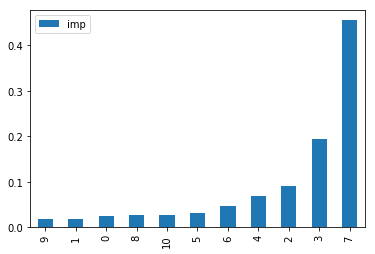

In [74]:
%matplotlib inline
fi = [{'var' : c, 'imp':f}for f,c in zip(rf.feature_importances_,X_col)]
df_fi = pd.DataFrame(fi).sort_values('imp')
print(df_fi)
df_fi.plot(kind='bar')  


In [75]:
print(df_fi)

         imp                                  var
9   0.016950                  max_target__shop_id
1   0.018863                  shop_id_mean_target
0   0.025583                     cats_mean_target
8   0.026452           max_target__month__shop_id
10  0.026530  min_target__month__item_id__shop_id
5   0.031239                    max_target__month
6   0.045798           max_target__month__item_id
4   0.068728                                lag12
2   0.091455                  item_id_mean_target
3   0.193246                                lag01
7   0.455156  max_target__month__item_id__shop_id


In [76]:
predictions[:5]

array([0. , 0.2, 0. , 0. , 0. ])

In [77]:
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:', round(mean_absolute_error(y_test,predictions), 2), '.')

Mean Absolute Error: 0.12 .


In [78]:
#pd.DataFrame(errors).hist(bins=50)

In [79]:
df_sub = df_ts.copy()
df_sub['month'] = 11
df_sub['year'] = 2015
print(df_sub.shape)

df_sub = pd.merge(df_sub,df_item_cat,on='item_id')
print(df_sub.shape)


(214200, 5)
(214200, 6)


In [80]:
print(df_sub.shape)
for c in X_col:
    if c.endswith('mean_target'):
        col_ogm = c.split('_mean_')[0]
        b  = df_model_base[[col_ogm,c]].groupby(col_ogm,as_index=False).max()
        df_sub = pd.merge(df_sub, b,left_on=col_ogm, right_on=b.columns[0],how='left')
    elif c == 'max_target' or c == 'min_target':
        df_sub[c] = max(df_model_base[c])
    elif c.startswith('min_') or c.startswith('max_'):
        cols_agrupadas = c.split('__')[1:]
        b = df_model_base[cols_agrupadas + [c]].groupby(cols_agrupadas,as_index=False).max()
        df_sub = pd.merge(df_sub, b,on=cols_agrupadas,how='left')
target_lag01 = df_model_base[df_model_base.ano_mes == '2015_10'][['target','shop_id','item_id']].reset_index()
target_lag01.columns = ['lag01' if c == 'target' else c for c in target_lag01.columns]
df_sub = pd.merge(df_sub, target_lag01,on=['shop_id','item_id'],how='left')
target_lag12 = df_model_base[df_model_base.ano_mes == '2014_11'][['target','shop_id','item_id']].reset_index()
target_lag12.columns = ['lag12' if c == 'target' else c for c in target_lag12.columns]
df_sub = pd.merge(df_sub, target_lag12,on=['shop_id','item_id'],how='left')


(214200, 6)


In [81]:
df_sub.head()

,ID,shop_id,item_id,month,year,cats,cats_mean_target,shop_id_mean_target,item_id_mean_target,max_target__month,...,max_target__month__item_id__shop_id,max_target__month__shop_id,max_target__shop_id,min_target__month__item_id__shop_id,shop_item_x,dt_x,lag01,shop_item_y,dt_y,lag12
0,0,5,5037,11,2015,Consoles Games,0.347987,0.174285,0.737914,989.0,...,1.0,92.0,155.0,0.0,00005_005037,2015-10-01,0.0,00005_005037,2014-11-01,1.0
1,5100,4,5037,11,2015,Consoles Games,0.347987,0.162158,0.737914,989.0,...,0.0,164.0,227.0,0.0,00004_005037,2015-10-01,0.0,00004_005037,2014-11-01,0.0
2,10200,6,5037,11,2015,Consoles Games,0.347987,0.223467,0.737914,989.0,...,4.0,154.0,309.0,0.0,00006_005037,2015-10-01,1.0,00006_005037,2014-11-01,4.0
3,15300,3,5037,11,2015,Consoles Games,0.347987,0.153364,0.737914,989.0,...,2.0,58.0,178.0,0.0,00003_005037,2015-10-01,0.0,00003_005037,2014-11-01,2.0
4,20400,2,5037,11,2015,Consoles Games,0.347987,0.173413,0.737914,989.0,...,0.0,87.0,138.0,0.0,00002_005037,2015-10-01,0.0,00002_005037,2014-11-01,0.0


In [82]:
df_sub.set_index('ID',inplace=True)
df_sub = df_sub[X_col]


In [83]:
#Mean of target on train set
df_sub['lag12'].fillna(0.251265,inplace=True)
df_sub['lag01'].fillna(0.251265,inplace=True)
df_sub.fillna(0,inplace=True,axis=1)


In [84]:
df_sub[df_sub.isnull().any(axis=1)]

,cats_mean_target,shop_id_mean_target,item_id_mean_target,lag01,lag12,max_target__month,max_target__month__item_id,max_target__month__item_id__shop_id,max_target__month__shop_id,max_target__shop_id,min_target__month__item_id__shop_id
ID,,,,,,,,,,,


In [50]:
y_sub = rf.predict(df_sub)

In [51]:
y_sub[:5]

array([0. , 0. , 0.1, 0. , 0. ])

In [52]:
rstd = []
for x,y in zip(df_sub.index.values,y_sub):
    rstd.append({'ID' : x, 'item_cnt_month' : y})

In [53]:
pd.DataFrame(rstd).to_csv('submission18-04-20.csv',index=False)